In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.express as px
px.defaults.width, px.defaults.height = 1000,600
np.random.seed(42)
pd.set_option('display.precision', 4)

## Pull and Check Data

In [2]:
website = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
djia = pd.read_html(website)[1].Symbol.to_list()
data = [yf.download(symbol, start="2019-01-01", end="2024-03-20", progress=False).reset_index() for symbol in djia]
data = pd.concat(data, keys=djia, names=['Symbol']).reset_index()[['Date', 'Symbol', 'Adj Close']]
data = data.pivot(index='Date', columns='Symbol', values='Adj Close')
continuous = data.dropna().index
returns = data.pct_change().dropna()
print("We have continuous data from {} to {}".format(continuous[0], continuous[-1]))
print('For the following assets:', returns.columns.to_list())

We have continuous data from 2019-03-20 00:00:00 to 2024-03-19 00:00:00
For the following assets: ['AAPL', 'AMGN', 'AMZN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WMT']


## Portfolio Statistics

In [3]:
# let's optimize a portfolio with the top X assets by average return
X = 5
top = returns.mean().sort_values(ascending=False)[:X].index.to_list()
returns_port = returns[top]

In [4]:
assets = pd.DataFrame(columns=['asset', 'mean', 'vol', 'weight'])
assets['asset'] = returns_port.columns
assets['mean'] = (returns_port.mean() * 252).values
assets['vol'] = (returns_port.std() * np.sqrt(252)).values
assets['weight'] = np.nan

R = returns_port.corr().values

### Formulating the Optimization Problem
Minimize the portfolio variance subject to the constraint that the expected return equals a target value 'm' and sum of weights equals 1.

$ min_{w} \frac{1}{2} w' \Sigma w$ subject to $w'\mu = m$ and $w'1 = 1$


### Objective Function

$ L(x, \lambda) = f(x) + \Sigma_{j=1}^m \lambda_j (g_j(x) - b_j)$
    
Where $f(x)$ is the variance function, $g_j(x)$ are the constraint functions, and $\lambda_j$ are the Lagrange multipliers.

### Lagrangian
$
L(w, \lambda, \gamma) = \frac{1}{2} w^T \Sigma w + \lambda (m - w^T \mu) + \gamma (1 - w^T 1)
$

### Partial Derivatives
$$
\frac{\partial L}{\partial w} = \Sigma w - \lambda \mu - \gamma 1
$$
$$
\frac{\partial L}{\partial \lambda} = m - w^T \mu
$$
$$
\frac{\partial L}{\partial \gamma} = 1 - w^T 1
$$

In [12]:
# set the target return to the average return of the assets +3%
m = assets['mean'].mean() + 0.03
mu = np.array(assets['mean'])
s = np.array(assets['vol'])
S = np.diag(s)
Sigma = S @ R @ S
Sigma_inv = np.linalg.inv(Sigma)

There's a ton of nuance with the returns, risk, and covariance matrix one might use here. We're using the historical average returns and standard deviations of the assets as the expected return and risk of the portfolio. We're also using a simple covariance matrix based off five years of historical returns. This is a simplification and may not be the best choice for your use case (it's certainly not). What we really want are estimates of future returns, risks, and covariance among assets. Historical values are just a benchmark. Making better estimates is beyond the scope of this notebook.

In [13]:
assert np.allclose(s, np.sqrt(Sigma.diagonal()))
assert np.allclose(Sigma, Sigma.T)

Candidate Solution
Note we get this by setting dL/dw to 0 and solving for w
$$ w^* = \Sigma^{-1} (\lambda \mu + \gamma 1)$$
You'd also want to confirm that the second derivative is positive to ensure this is a minimum.

Optimal Allocations
Since we don't have the values for $\lambda$ and $\gamma$, we can't solve for $w^*$ directly. However, we can solve for $\lambda$ and $\gamma$ using the constraints and then solve for $w^*$.
$$ w^* = \frac{1}{A C - B^2} \Sigma^{-1} ((A \mu - B1) m + (C1 - B \mu))$$

In [14]:
ones = np.ones(mu.shape)

A = ones.T @ Sigma_inv @ ones
B = mu.T @ Sigma_inv @ ones
C = mu.T @ Sigma_inv @ mu

lam = (A*m - B) / (A*C - B**2)
gam = (C - B*m) / (A*C - B**2)

### Portfolio Weights, Risk, and Return

In [15]:
w_star = (1/(A*C - B**2)) * Sigma_inv @ ((A*mu - B*ones) * m + (C*ones - B*mu))
sigma_p = np.sqrt(w_star @ Sigma @ w_star)
mu_p = w_star @ mu

In [16]:
# confirm our weights sum to 1, our portfolio return is m, and our weights align with candidate solution
assert np.isclose(w_star.sum(), 1)
assert np.isclose(mu_p, m)
assert np.allclose(w_star, Sigma_inv @ (lam*mu + gam*ones))

### Optimal Portfolio

In [17]:
assets_solved = pd.DataFrame(columns=['asset', 'mean', 'vol', 'weight'],
                             data=[[assets['asset'][i], mu[i], s[i], w_star[i]] for i in range(len(mu))])
optimal_portfolio = {'mu_p': mu_p, 'sigma_p': sigma_p, 'w_star': w_star}

print(assets_solved.head(), '\n')
for key in optimal_portfolio:
    print(f'{key}: {optimal_portfolio[key]}')

  asset    mean     vol  weight
0  AAPL  0.3225  0.3174  0.2371
1  MSFT  0.3120  0.3039  0.3833
2   CAT  0.2721  0.3220  0.3894
3   AXP  0.2238  0.3789 -0.0818
4    GS  0.2158  0.3242  0.0720 

mu_p: 0.2992382571966902
sigma_p: 0.25340426079118294
w_star: [ 0.23714484  0.38327564  0.3894304  -0.08181086  0.07195997]


### Show the Efficient Frontier

- Generate random allocation sets. 
- Each set has to satisfy the constraint w′1 = 1.
- Compute $\mu_{\Pi} = w'\mu$ and $\sigma_{\Pi} = \sqrt{w' \Sigma w}$ for each set.
- Plot points with coordinates $\mu_{\Pi}$ on the vertical axis and $\sigma_{\Pi}$ on the horizontal axis.

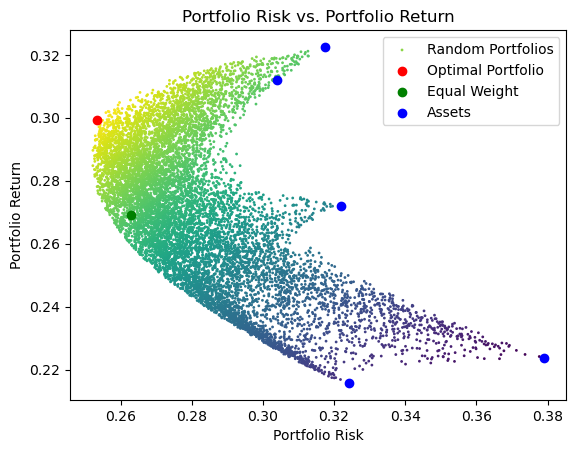

In [19]:
# simulate n random portfolios
n_sims = 10000
n_assets = len(mu)
alpha = 0.5
weights = np.random.dirichlet(n_assets*[alpha], n_sims)

# compute portfolio returns and risks
mu_p = weights @ mu
sigma_p = np.sqrt(np.diag(weights @ Sigma @ weights.T))

# compute equal-weighted portfolio returns and risks
weights_eq = np.ones(n_assets) / n_assets
mu_eq = weights_eq @ mu
sigma_eq = np.sqrt(weights_eq @ Sigma @ weights_eq)

# plot the portfolios
plt.scatter(sigma_p, mu_p, s=1, c=mu_p/sigma_p)
plt.xlabel('Portfolio Risk')
plt.ylabel('Portfolio Return')
plt.title('Portfolio Risk vs. Portfolio Return')
plt.scatter(optimal_portfolio['sigma_p'], optimal_portfolio['mu_p'], color='red')
plt.scatter(sigma_eq, mu_eq, color='green')
for i in range(len(mu)):
    plt.scatter(s[i], mu[i], color='blue')
plt.legend(['Random Portfolios', 'Optimal Portfolio', 'Equal Weight', 'Assets'])
plt.show()

The plot results in a hyperbola since the portfolio return (y-axis) is a linear function of the weights, while the portfolio risk (x-axis) is a quadratic function of the weights.

Return = $\Sigma_{i=1}^n w_iR_i$

Risk = $\sqrt{\Sigma_{i=1}^n \Sigma_{j=1}^n w_i \Sigma_{ij} w_j}$
